## Process :

- 0) Data Preprocess
- 1) ML
- 2) Ensemble

## model ref :

- nb :
    
    https://www.kaggle.com/shs037ucsd/predict-match-between-two-person-v1
    

- Classifier :
http://scikitlearn.org/stable/auto_examples/classification/plot_classifier_comparison.html

=========================================================

In [1]:
# Load basic library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import pylab as pl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# * 0 ) Data Preprocess 

In [2]:
df = pd.read_csv("/Users/yennanliu/Kaggle.com_mini_project/Speed_Dating/Speed_Dating_Data.csv", encoding="ISO-8859-1")
#input_vars = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']

In [3]:
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [4]:
shape(df)

(8378, 195)

In [5]:
### ONLY USING SPECIFIC FEATURES 

def data_preprocess(df):
    use_features = ['iid', 'gender', 'wave', 'pid', 'match', 'samerace', 'age_o', 'race_o', \
                     'pf_o_att', 'pf_o_sin', 'pf_o_int','pf_o_fun', 'pf_o_amb', 'pf_o_sha',\
                     'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal', 'date', 'go_out', 'sports',\
                     'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',\
                     'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy',\
                     'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr2_1', 'sinc2_1',\
                     'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1','fun3_1', 'intel3_1', 'amb3_1']

    df_ = df[use_features]
    # get data where wave 1-5, 10-21 where people use pts measure
    df_ = df_[(df_['wave']>9)|(df_['wave']<6)]
    return df_


In [6]:
df_ = data_preprocess(df)
df_.head(3)

,iid,gender,wave,pid,match,samerace,age_o,race_o,pf_o_att,pf_o_sin,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
0,1,0,1,11.0,0,0,27.0,2.0,35.0,20.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,1,0,1,12.0,0,0,22.0,2.0,60.0,0.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,1,0,1,13.0,1,1,22.0,4.0,19.0,18.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0


In [31]:
#df_[df_.wave == 6]['wave']

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-06-13 19:19:36.668751. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [8]:
df_.groupby('match').count()['pid']

match
0    5682
1    1124
Name: pid, dtype: int64

### data in- equilibrium 
> no match cases (match = 0 ) are MUCH MORE than match cases (match = 1),
> need to do either re-sample nor sub-sample tricks following steps dealing with this issue

In [9]:
# only keep rows which have non-null data 
# https://stackoverflow.com/questions/36370839/better-way-to-drop-nan-rows-in-pandas

df_ = df_.dropna(how='any')

## 0-1) help function 

In [10]:

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

def train_test_separate(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    return X_train, X_test, y_train, y_test


def basic_fitting(X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    # ====  fitting ====
    model_clf = model
    model_clf.fit(X_train, y_train)
    #print (model_clf)
    print ('test data score : ', model_clf.score(X_test,y_test))
    print ('\n')
    # ====  confusion matrix  ====
    print ('confusion matrix : ')
    print (confusion_matrix(y_test, model_clf.predict(X_test),labels=[0,1]))
    # ====  ROC curve  ====
    fpr, tpr, _ = roc_curve(y_test, model_clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    print ('ROC AUC: %0.2f' % roc_auc)
    # plot curve 
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def model_comparison(models,*args,**kwargs):
    #models = [clf_svc,clf_tree,clf_rf]
    
    for model in models: 
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        roc_auc = auc(fpr, tpr)
        print ('ROC AUC: %0.2f' % roc_auc)
        # plot curve 
        #plt.figure()
        plt.plot(fpr, tpr, label='{} ROC curve (area = %0.2f)' % roc_auc)
        #plt.plot(fpr, tpr, label='ROC curve (area = {}0.2f)'.format(roc_auc))
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


# * 1) ML 

### 1-0)  input, output values define

In [11]:
# X : inpurt feature
# y : output value

X = df_.drop('match', axis=1)
y = df_[['match']]

In [12]:
X_train, X_test, y_train, y_test = train_test_separate(X,y)

### 1-1) Support Vector Classifier

test data score :  0.76138996139


confusion matrix : 
[[925 144]
 [165  61]]
ROC AUC: 0.57


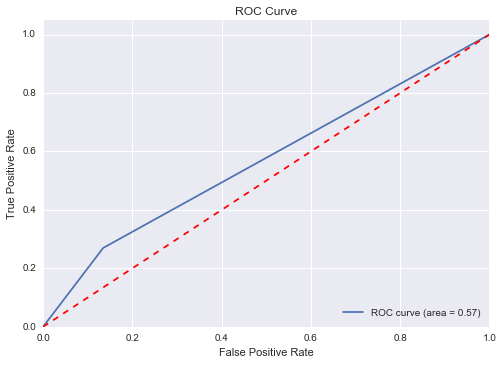

In [13]:
from sklearn.tree import DecisionTreeClassifier
clf_svc = DecisionTreeClassifier(random_state=0)
#clf_svc.fit(X_train, y_train)
#clf_svc.score(X_test,y_test)

basic_fitting(X,y,clf_svc)

### 1-2) Decision Tree Classifier

test data score :  0.76138996139


confusion matrix : 
[[925 144]
 [165  61]]
ROC AUC: 0.57


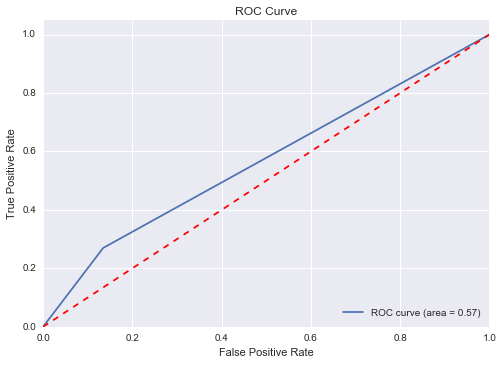

In [14]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=0)

basic_fitting(X,y,clf_tree)

### 1-3) Random Forest Classifier

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


test data score :  0.814671814672


confusion matrix : 
[[1031   38]
 [ 202   24]]
ROC AUC: 0.64


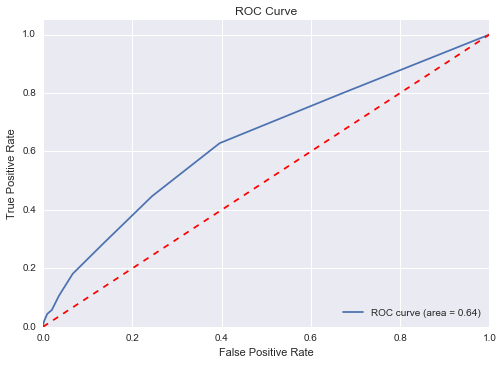

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=0)

basic_fitting(X,y,clf_rf)


### 1-4) K Neighbors Classifier

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


test data score :  0.801544401544


confusion matrix : 
[[1015   54]
 [ 203   23]]
ROC AUC: 0.61


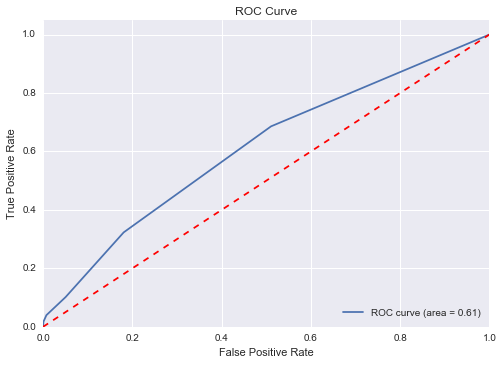

In [16]:
from sklearn.neighbors import KNeighborsClassifier

clf_kn = KNeighborsClassifier()

basic_fitting(X,y,clf_kn)

### 1-5) neural network Classifier

//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:904: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test data score :  0.817760617761


confusion matrix : 
[[1050   19]
 [ 217    9]]
ROC AUC: 0.55


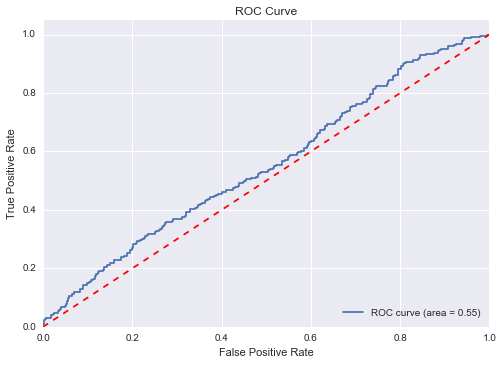

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-06-13 19:19:59.585051. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [32]:
from sklearn.neural_network import MLPClassifier

clf_nn = MLPClassifier()

basic_fitting(X,y,clf_nn)


### 1-x) Model Comparison

ROC AUC: 0.57
ROC AUC: 0.57
ROC AUC: 0.64
ROC AUC: 0.61
ROC AUC: 0.55


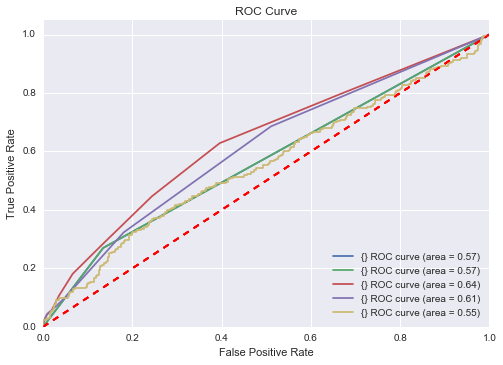

In [18]:
models = [clf_svc,clf_tree,clf_rf,clf_kn,clf_nn]
model_comparison(models)

### 1-x) XGBClassifier

//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test data score :  0.828571428571


confusion matrix : 
[[1065    4]
 [ 218    8]]
ROC AUC: 0.67


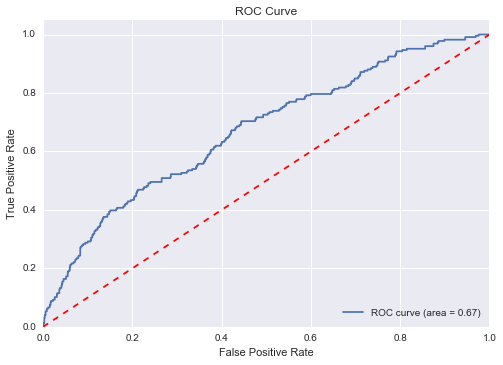

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-06-13 19:17:44.195612. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [19]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

clf_XGBC = XGBClassifier()
basic_fitting(X,y,clf_XGBC)

# * 2) Ensemble

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-06-13 19:17:45.419429. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [21]:
#  VotingClassifier
#  http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#  accuracy_score
#  http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()


//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-06-13 19:17:45.506153. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [22]:
# voting : hard 

eclf1 = VotingClassifier(estimators=[
     ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
accuracy_score(eclf1.predict(X_test),y_test)

//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.82779922779922777

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-06-13 19:17:45.515433. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [23]:
# voting : soft 

eclf1 = VotingClassifier(estimators=[
     ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train)
accuracy_score(eclf1.predict(X_test),y_test)

//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.82239382239382242

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-06-13 19:17:46.017314. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [24]:
# Chane other models (DecisionTreeClassifier ,KNeighborsClassifier )
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier(random_state=1)
clf3 = KNeighborsClassifier()


//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-06-13 19:17:46.463444. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [26]:
# voting : soft 

eclf1 = VotingClassifier(estimators=[
     ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train)
accuracy_score(eclf1.predict(X_test),y_test)

//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.80231660231660229

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-06-13 19:17:55.107180. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
